# TRANSFORMACIÓN DE DATOS

## IMPORTAR PAQUETES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

#Automcompletar rápido
%config IPCompleter.greedy=True

## IMPORTAR LOS DATOS

1.- Indicamos la ruta del proyecto.

In [2]:
ruta_proyecto = r'C:\Users\mcent\OneDrive\Escritorio\PROYECTOS ML\SCORING_DE_RIESGOS'

2.- Nombramos los ficheros de datos.

In [3]:
nombre_cat = 'cat_resultado_eda.pickle'
nombre_num = 'num_resultado_eda.pickle'

3.- Cargamos los datos.

In [4]:
cat = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_cat)
num = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_num)

Recordamos lo que habíamos identificado en fases anteriores y lo organizamos por tipo de acción.

**Modificar con pandas/numpy:**

* Crear la target a partir de estado
* Discretizar num_meses_desde_ult_retraso
* En vivienda juntar NONE y OTHER
* En finalidad juntar renewable_energy, educational y vacation en 'otros'

**Modificar con scikit learn:**

* La variable descripcion podríamos trabajarla con un TF-IDF Vectorizer
* Convertir num_derogatorios a binaria

## CREACIÓN Y TRANSFORMACIÓN DE VARIABLES CON PANDAS

### CREAMOS LAS VARIABLES TARGETS PARA LOS 3 MODELOS

In [5]:
cat.estado.value_counts()

Fully Paid            59389
Current               48476
Charged Off           14560
Late (31-120 days)     1203
In Grace Period         484
Late (16-30 days)       240
Default                   1
Name: estado, dtype: int64

#### PD - Probability of Default

Asignamos valor 1 para aquellos estados considerados default y 0 para los que no

In [160]:
cat['pd'] = np.where(cat.estado.isin(['Charged Off','Does not meet the credit policy. Status:Charged Off','Default']), 1, 0)
cat

,empleo,antiguedad_empleo,ingresos_verificados,rating,vivienda,descripcion,finalidad,num_cuotas,estado,pd
id_cliente,,,,,,,,,,
137387967,Hvac technician,3 years,Source Verified,A,MORTGAGE,Sin informacion,debt_consolidation,36 months,Current,0
4798121,"Target Promotions and Marketing,Inc",10+ years,Not Verified,D,RENT,Sin informacion,debt_consolidation,36 months,Charged Off,1
46641215,Banker,5 years,Verified,A,RENT,Sin informacion,debt_consolidation,36 months,Fully Paid,0
87998444,executive director,9 years,Source Verified,B,MORTGAGE,Sin informacion,credit_card,60 months,Current,0
132883631,Subsea Technician,7 years,Source Verified,B,MORTGAGE,Sin informacion,debt_consolidation,36 months,Fully Paid,0
...,...,...,...,...,...,...,...,...,...,...
51856888,Executive Assistant,3 years,Source Verified,B,RENT,Sin informacion,credit_card,36 months,Fully Paid,0
144538772,Immigration Senior Paralegal,7 years,Not Verified,B,MORTGAGE,Sin informacion,credit_card,36 months,Current,0
73222117,Executive Assistant,10+ years,Verified,B,RENT,Sin informacion,debt_consolidation,36 months,Fully Paid,0


In [161]:
cat.drop(columns='estado',inplace=True)

#### EAD 

Será el porcentaje del principal que no había sido amortizado.

Por tanto: pendiente / principal

Primero tenemos que construir el pendiente como el principal menos el amortizado.

In [ ]:
num['pendiente'] = num['principal'] - num['imp_amortizado']

In [163]:
temp = pd.concat([cat,num], axis = 1)
temp[['imp_recuperado','imp_amortizado','principal']]

,imp_recuperado,imp_amortizado,principal
id_cliente,,,
137387967,0.00,2669.06,15000.0
4798121,0.00,6362.96,10000.0
46641215,0.00,24000.00,24000.0
87998444,0.00,12443.00,27000.0
132883631,0.00,22000.00,22000.0
...,...,...,...
51856888,0.00,5000.00,5000.0
144538772,0.00,1763.67,25000.0
73222117,0.00,3000.00,3000.0


In [164]:
num['ead'] = (num.pendiente/num.principal)

#### LG - Loss Given Default

Será el porcentaje del pendiente que NO se recupera en caso de impago.

Por tanto: 1 - (imp_recuperado / pendiente)

In [165]:
num['lg'] = (1 - num.imp_recuperado/num.pendiente)

In [166]:
num.lg.fillna(0,inplace=True)

**ANALIZAMOS LA CANTIDAD DE 1 EN NUESTRAS TARGETS**

In [167]:
num[['ead','lg']].describe().T

,count,mean,std,min,25%,50%,75%,max
ead,124353.0,0.335029,0.367483,-0.000001,0.0,0.126608,0.719281,1.0
lg,124353.0,0.507436,0.490303,-0.264347,0.0,0.845639,1.000000,1.0


**MODELIZAMOS PARA LLEVAR A 0 LOS VALORES NEGATIVOS**

In [168]:
num['ead'] = np.where(num.ead < 0, 0, num.ead)
num['lg'] = np.where(num.lg < 0, 0, num.lg)
num[['ead','lg']].describe().T

,count,mean,std,min,25%,50%,75%,max
ead,124353.0,0.335029,0.367483,0.0,0.0,0.126608,0.719281,1.0
lg,124353.0,0.507459,0.490277,0.0,0.0,0.845639,1.000000,1.0


## RESTO DE VARIABLES

In [169]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124353 entries, 137387967 to 53664762
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   empleo                124353 non-null  object
 1   antiguedad_empleo     124353 non-null  object
 2   ingresos_verificados  124353 non-null  object
 3   rating                124353 non-null  object
 4   vivienda              124353 non-null  object
 5   descripcion           124353 non-null  object
 6   finalidad             124353 non-null  object
 7   num_cuotas            124353 non-null  object
 8   pd                    124353 non-null  int32 
dtypes: int32(1), object(8)
memory usage: 9.0+ MB


**Analizamos num_meses_ult_retraso**

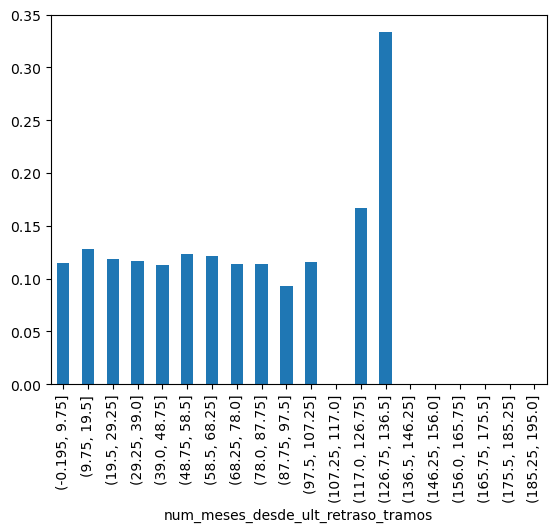

In [170]:
temp = num[['num_meses_desde_ult_retraso']].copy()
temp['num_meses_desde_ult_retraso_tramos'] = pd.cut(temp.num_meses_desde_ult_retraso, 20)
temp['target'] = cat['pd']

temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean().plot.bar();

La distribución de esta variable no genera mucha confianza. Al ser una variable de comportamiento, la descartamos.

In [171]:
num.drop(columns='num_meses_desde_ult_retraso',inplace=True)

**Imputamos finalidad y vivienda**

In [172]:
cat['finalidad'] = cat.finalidad.replace(['house','renewable_energy','educational','wedding'],'other')
cat['vivienda'] = cat.vivienda.replace(['NONE','ANY','OTHER'],'MORTGAGE')

In [173]:
cat.finalidad.value_counts()

debt_consolidation    71193
credit_card           28443
other                  8367
home_improvement       7985
major_purchase         2752
medical                1439
small_business         1293
car                    1166
vacation                868
moving                  847
Name: finalidad, dtype: int64

In [174]:
cat.vivienda.value_counts()

MORTGAGE    61498
RENT        49875
OWN         12980
Name: vivienda, dtype: int64

**Imputamos dti**

In [175]:
variable = ['dti']
minimo = 0
maximo = 100
num[variable] = num[variable].clip(minimo,maximo)

**Eliminamos empleo ya que presenta gran variabilidad y, se considera más importante los ingresos y la antiguedad**

**También eliminamos resto de variables que ya no usaremos**

In [176]:
cat.drop(columns=['empleo'], inplace= True)
num.drop(columns=['imp_recuperado','imp_amortizado','pendiente'], inplace = True)

## TRANSFORMACIÓN DE CATEGÓRICAS

#### Variables a aplicar OHE

In [177]:
cat.columns.to_list()

['antiguedad_empleo',
 'ingresos_verificados',
 'rating',
 'vivienda',
 'descripcion',
 'finalidad',
 'num_cuotas',
 'pd']

In [178]:
var_ohe = ['ingresos_verificados',
 'vivienda',
 'finalidad',
 'num_cuotas']

#### Instanciar

In [179]:
ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')

#### Entrenar y aplicar

In [180]:
cat_ohe = ohe.fit_transform(cat[var_ohe])

#### Guardar como dataframe

In [181]:
cat_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names_out())

### Ordinal Encoding

#### Variables a aplicar OE

In [182]:
cat.antiguedad_empleo.unique()

array(['3 years', '10+ years', '5 years', '9 years', '7 years', '8 years',
       '4 years', '< 1 year', '1 year', '6 years', '2 years'],
      dtype=object)

In [184]:
var_oe = ['rating','antiguedad_empleo']

#### Orden de los valores de las variables

In [185]:
#Orden de la primera variable
orden_rating = ['G','F','E','D','C','B','A']
orden_antiguedad_empleo = ['< 1 year', '1 year','2 years','3 years','4 years',
                           '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']

#### Instanciar

In [186]:
oe = OrdinalEncoder(categories = [orden_rating,orden_antiguedad_empleo],
                    handle_unknown = 'use_encoded_value',
                    unknown_value = 11)

#### Entrenar y aplicar

In [187]:
cat_oe = oe.fit_transform(cat[var_oe])

#### Guardar como dataframe

In [188]:
#Añadir sufijos a los nombres
nombres_oe = [variable + '_oe' for variable in var_oe]

#Guardar como dataframe
cat_oe = pd.DataFrame(cat_oe, columns = nombres_oe)

### Fechas y Textos

In [189]:
stop = pd.read_csv(r'C:\Users\mcent\OneDrive\Escritorio\PROYECTOS ML\SCORING_DE_RIESGOS\01_Documentos\stop_words_english.txt', names= ['terminos'])

In [190]:
def quitar_tildes(palabra):
    #Definimos la versión con tildes y símbolos y la sin
    con = 'áéíóúüñÁÉÍÓÚÜÑ'
    sin = 'aeiouunAEIOUUN'
    #Creamos un traductor
    traductor = str.maketrans(con,sin)
    #Aplicamos el traductor y devolvemos la palabra limpia
    return(palabra.translate(traductor))

In [191]:
stop['limpias'] = stop.terminos.transform(quitar_tildes)

Aplicamos tf-fidVectorizer

In [192]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Instanciamos
tfidf = TfidfVectorizer(strip_accents = 'unicode',
                     stop_words = stop.limpias.to_list(),
                     max_df = 0.7,
                     min_df = 50,
                     ngram_range= (1,3))

#Entrenamos
tfidf.fit(cat.descripcion)

#Aplicamos
caracteristicas = tfidf.transform(cat.descripcion)

C:\Users\mcent\miniconda3\envs\riesgos\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'al', 'couldn', 'daren', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'itse', 'll', 'mayn', 'mightn', 'mon', 'mustn', 'myse', 'needn', 'oughtn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [125]:
tfidf.vocabulary_

{'borrower': 144,
 '11': 36,
 '14': 71,
 '12': 39,
 'credit': 212,
 'card': 173,
 'debt': 229,
 'loan': 284,
 'order': 313,
 'pay': 316,
 'consolidating': 204,
 'payment': 330,
 'cards': 180,
 'br': 157,
 'wedding': 374,
 'months': 310,
 'goal': 258,
 'higher': 269,
 'personal': 337,
 'consolidate': 197,
 'payments': 333,
 'month': 304,
 'borrower 11': 155,
 '14 12': 72,
 'credit card': 213,
 'card debt': 178,
 'cards loan': 184,
 'payment br': 331,
 'br br': 166,
 'br borrower': 158,
 'loan pay': 292,
 'pay higher': 325,
 'personal loan': 338,
 'loan credit': 289,
 'credit cards': 219,
 'consolidate debt': 202,
 'payment month': 332,
 'month br': 305,
 'credit card debt': 218,
 'br br borrower': 167,
 '07': 23,
 '23': 107,
 '13': 52,
 'balance': 138,
 'score': 362,
 'purchase': 340,
 'years': 378,
 'borrower 07': 151,
 '23 13': 109,
 '13 consolidate': 55,
 'consolidate credit': 199,
 'credit score': 226,
 'years br': 379,
 '13 consolidate credit': 56,
 'consolidate credit card': 200,


## TRANSFORMACIÓN DE NUMÉRICAS

### Binarizar variables

#### Variables a binarizar

In [193]:
num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124353 entries, 137387967 to 53664762
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ingresos                   124353 non-null  float64
 1   dti                        124353 non-null  float64
 2   num_hipotecas              124353 non-null  Int64  
 3   num_lineas_credito         124353 non-null  Int64  
 4   porc_tarjetas_75p          124353 non-null  float64
 5   porc_uso_revolving         124353 non-null  float64
 6   num_cancelaciones_12meses  124353 non-null  Int64  
 7   num_derogatorios           124353 non-null  Int64  
 8   principal                  124353 non-null  float64
 9   tipo_interes               124353 non-null  float64
 10  imp_cuota                  124353 non-null  float64
 11  ead                        124353 non-null  float64
 12  lg                         124353 non-null  float64
dtypes: Int64(4), float6

In [194]:
var_bin = ['num_derogatorios']

#### Instanciar

In [195]:
bin = Binarizer(threshold=0) # THRESHOLD Es el umbral, ya que él 75% de los derogatoriso son 0, le damos ese valor.

#### Entrenar y aplicar

In [196]:
num_bin = bin.fit_transform(num[var_bin])

#### Guardar como dataframe

In [197]:
#Añadir sufijos a los nombres
nombres_bin = [variable + '_bin' for variable in var_bin]

#Guardar como dataframe
num_bin = pd.DataFrame(num_bin,columns = nombres_bin)

## REESCALAR VARIABLES

**VARIABLES A REESCALAR**

In [198]:
num_escalar = num[['ingresos',
 'dti',
 'num_hipotecas',
 'num_lineas_credito',
 'porc_tarjetas_75p',
 'porc_uso_revolving',
 'num_cancelaciones_12meses',
 'principal',
 'tipo_interes',
 'imp_cuota']].reset_index(drop = True)

In [199]:
df_res = pd.concat([num_escalar,cat_oe], axis = 1)
df_res

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,principal,tipo_interes,imp_cuota,rating_oe,antiguedad_empleo_oe
0,54000.0,19.31,2,10,33.3,45.2,0,15000.0,7.21,464.60,6.0,3.0
1,65000.0,25.40,1,15,85.7,86.2,0,10000.0,17.77,360.38,3.0,10.0
2,135000.0,14.68,0,19,0.0,16.3,0,24000.0,6.39,734.38,6.0,5.0
3,188000.0,11.69,3,15,0.0,3.3,0,27000.0,8.99,560.35,5.0,9.0
4,125000.0,9.00,1,6,33.3,69.9,0,22000.0,10.90,719.22,5.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
124348,55000.0,18.33,2,9,60.0,46.7,0,5000.0,9.99,161.32,5.0,3.0
124349,200000.0,5.57,2,11,75.0,64.7,0,25000.0,11.80,827.98,5.0,7.0
124350,85000.0,33.05,1,25,90.0,76.0,1,3000.0,9.75,96.45,5.0,10.0
124351,55000.0,15.36,1,7,75.0,81.7,0,14400.0,17.47,361.53,3.0,10.0


### Con Min-Max

#### Variables a reescalar con Min-Max

In [200]:
var_mms = df_res.columns

#### Instanciar

In [201]:
mms = MinMaxScaler()

#### Entrenar y aplicar

In [202]:
df_mms = mms.fit_transform(df_res[var_mms])

#### Guardar como dataframe

In [203]:
#Añadir sufijos a los nombres
nombres_mms = [variable + '_mms' for variable in var_mms]

#Guardar como dataframe
df_mms = pd.DataFrame(df_mms,columns = nombres_mms)

## UNIFICAR DATASETS TRANSFORMADOS

In [228]:
pd.options.display.max_columns = 6

### Creación de lista de dataframes a unir para modelo PD

In [211]:
incluir_pd = [cat_ohe, df_mms,num_bin,cat.reset_index()[['id_cliente','pd']]]

In [212]:
df_pd = pd.concat(incluir_pd, axis = 1)

In [213]:
df_pd.set_index('id_cliente', inplace= True)

In [229]:
df_pd

,ingresos_verificados_Not Verified,ingresos_verificados_Source Verified,ingresos_verificados_Verified,...,antiguedad_empleo_oe_mms,num_derogatorios_bin,pd
id_cliente,,,,,,,
137387967,0.0,1.0,0.0,...,0.3,0.0,0
4798121,1.0,0.0,0.0,...,1.0,0.0,1
46641215,0.0,0.0,1.0,...,0.5,0.0,0
87998444,0.0,1.0,0.0,...,0.9,0.0,0
132883631,0.0,1.0,0.0,...,0.7,0.0,0
...,...,...,...,...,...,...,...
51856888,0.0,1.0,0.0,...,0.3,0.0,0
144538772,1.0,0.0,0.0,...,0.7,0.0,0
73222117,0.0,0.0,1.0,...,1.0,0.0,0


### Creación de lista de dataframes a unir para modelo EAD

In [214]:
incluir_ead = [cat_ohe, num_bin, df_mms,num.reset_index()[['id_cliente','ead']]]

In [215]:
df_ead = pd.concat(incluir_ead, axis = 1)

In [216]:
df_ead.set_index('id_cliente', inplace= True)

In [230]:
df_ead

,ingresos_verificados_Not Verified,ingresos_verificados_Source Verified,ingresos_verificados_Verified,...,rating_oe_mms,antiguedad_empleo_oe_mms,ead
id_cliente,,,,,,,
137387967,0.0,1.0,0.0,...,1.000000,0.3,0.822063
4798121,1.0,0.0,0.0,...,0.500000,1.0,0.363704
46641215,0.0,0.0,1.0,...,1.000000,0.5,0.000000
87998444,0.0,1.0,0.0,...,0.833333,0.9,0.539148
132883631,0.0,1.0,0.0,...,0.833333,0.7,0.000000
...,...,...,...,...,...,...,...
51856888,0.0,1.0,0.0,...,0.833333,0.3,0.000000
144538772,1.0,0.0,0.0,...,0.833333,0.7,0.929453
73222117,0.0,0.0,1.0,...,0.833333,1.0,0.000000


### Creación de lista de dataframes a unir para modelo LG

In [217]:
incluir_lg= [cat_ohe,cat_oe,num_bin, df_mms,num.reset_index()[['id_cliente','lg']]]

In [218]:
df_lg = pd.concat(incluir_lg, axis = 1)

In [219]:
df_lg.set_index('id_cliente', inplace= True)

In [231]:
df_lg

,ingresos_verificados_Not Verified,ingresos_verificados_Source Verified,ingresos_verificados_Verified,...,rating_oe_mms,antiguedad_empleo_oe_mms,lg
id_cliente,,,,,,,
137387967,0.0,1.0,0.0,...,1.000000,0.3,1.000000
4798121,1.0,0.0,0.0,...,0.500000,1.0,1.000000
46641215,0.0,0.0,1.0,...,1.000000,0.5,0.000000
87998444,0.0,1.0,0.0,...,0.833333,0.9,1.000000
132883631,0.0,1.0,0.0,...,0.833333,0.7,0.000000
...,...,...,...,...,...,...,...
51856888,0.0,1.0,0.0,...,0.833333,0.3,0.000000
144538772,1.0,0.0,0.0,...,0.833333,0.7,1.000000
73222117,0.0,0.0,1.0,...,0.833333,1.0,0.000000


In [232]:
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124353 entries, 137387967 to 53664762
Data columns (total 32 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ingresos_verificados_Not Verified     124353 non-null  float64
 1   ingresos_verificados_Source Verified  124353 non-null  float64
 2   ingresos_verificados_Verified         124353 non-null  float64
 3   vivienda_MORTGAGE                     124353 non-null  float64
 4   vivienda_OWN                          124353 non-null  float64
 5   vivienda_RENT                         124353 non-null  float64
 6   finalidad_car                         124353 non-null  float64
 7   finalidad_credit_card                 124353 non-null  float64
 8   finalidad_debt_consolidation          124353 non-null  float64
 9   finalidad_home_improvement            124353 non-null  float64
 10  finalidad_major_purchase              124353 non-null  flo

## GUARDAR DATASET TRAS TRANSFORMACIÓN DE DATOS

En formato pickle para no perder las modificaciones de metadatos.

In [220]:
#Definir los nombres del archivo
ruta_df_pd = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_pd'
ruta_df_ead = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_ead'
ruta_df_lg = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_lg'

In [221]:
#Guardar los archivos
df_pd.to_pickle(ruta_df_pd)
df_ead.to_pickle(ruta_df_ead)
df_lg.to_pickle(ruta_df_lg)